In [1]:
import os
import torch
import torchaudio
from torchaudio.transforms import Spectrogram
from utils import stereo_to_mono

data_dir = './fma/data/fma_small'
output_dir = './fma/data/spectrograms_2'
sampling_rate = 22_050
max_ms = 30_000
SUBSAMPLING = True

def spectro_gram(aud, n_mels=128, n_fft=1024, hop_len=512):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            try:
                filepath = os.path.join(root, filename)
            
                sig, sr = torchaudio.load(filepath)
                
                sig = stereo_to_mono(sig) 
    
                # resample to the desired sampling rate
                if sr != sampling_rate:
                    sig = torchaudio.transforms.Resample(sr, sampling_rate)(sig)

            
            
                if SUBSAMPLING:
                    subsample_length = sampling_rate * 5  # 5 seconds
                    overlap = int(subsample_length * 0.25)  # 25% overlap
                    subsamples = []
                    shift = subsample_length - overlap
                    for i in range(0, sig.size(0) - subsample_length + 1, shift):
                        subsample = sig[i:(i + subsample_length)]
                        subsamples.append(subsample)

                        if len(subsamples) == 7: break
            
                    # ignore samples that have less than 30s (it should not be the case but there is a 15s sample in validation dataset we dont know why)
                    if len(subsamples) != 7: continue
                    
                    for idx, subsample in enumerate(subsamples): 
                        # compute the spectrogram
                        spectro = spectro_gram(aud = (subsample, sampling_rate))

                        # save the spectrogram to the output directory
                        output_file = os.path.join(output_dir, filename[:-4] + f'_{idx}.pt')
                        torch.save(spectro, output_file)
                    
                else:
                    # resize to a fixed length
                    sig_len = sig.shape[0]
                    max_len = sampling_rate//1000 * max_ms
                    if sig_len > max_len:
                        sig = sig[:max_len]
                    elif sig_len < max_len:
                        pad_begin_len = random.randint(0, max_len - sig_len)
                        pad_end_len = max_len - sig_len - pad_begin_len
                        pad_begin = torch.zeros((num_rows, pad_begin_len))
                        pad_end = torch.zeros((num_rows, pad_end_len))
                        sig = torch.cat((pad_begin, sig, pad_end), 1)

                    # compute the spectrogram
                    spectro = spectro_gram(aud = (sig, sampling_rate))

                    # save the spectrogram to the output directory
                    output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                    torch.save(spectro, output_file)
            except:
                continue
            

The MelSpectrogram and Spectrogram transforms in torchaudio are used to convert time-domain audio signals into frequency-domain representations. The main difference between them is the way they map the frequencies of the audio signal to a new representation.<br>

A Spectrogram is a 2D representation of an audio signal where the x-axis represents time, and the y-axis represents frequency. The amplitude of each frequency component is represented by the intensity of the color at that point on the spectrogram.<br>

A MelSpectrogram, on the other hand, uses the Mel scale, which is a non-linear frequency scale that is based on the way humans perceive different frequencies. The Mel scale compresses the higher frequencies and expands the lower frequencies, which makes it more suitable for speech and music processing.<br>

In summary, MelSpectrogram is a spectrogram in which frequency axis is transformed to Mel-scale and it is more suitable for speech and music processing.

In [2]:
sp = torch.load('./fma/data/spectrograms_2/000002_1.pt')

/tmp/ipykernel_9265/635194330.py:13: RuntimeWarning: invalid value encountered in log
  cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')


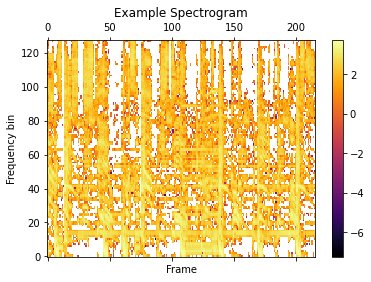

/tmp/ipykernel_9265/635194330.py:13: RuntimeWarning: divide by zero encountered in log
  cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')


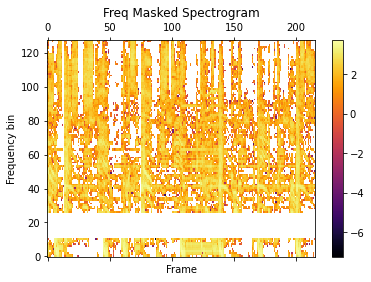

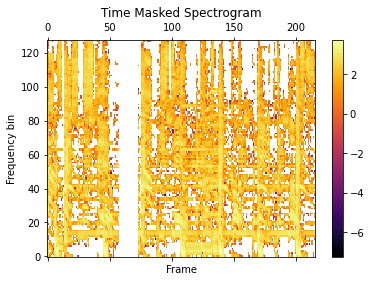

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(spectrogram, fs=8000, title="Spectrogram"):
    """Plots the spectrogram
    Args:
        spectrogram: numpy array, input spectrogram
        fs: int, sample rate of the signal
        title: str, title of the plot
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')
    fig.colorbar(cax)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Frequency bin")
    plt.show()

# Example usage
plot_spectrogram(sp, title="Example Spectrogram")
masked_sp = frequency_mask(sp)
plot_spectrogram(masked_sp, title="Freq Masked Spectrogram")
masked_sp = time_mask(sp)
plot_spectrogram(masked_sp, title="Time Masked Spectrogram")

In [17]:
import numpy as np

def frequency_mask(spectrogram, F=15, num_masks=1, replace_with_zero=True):
    """Applies frequency mask on the spectrogram
    Args:
        spectrogram: numpy array, input spectrogram
        F: int, maximum size of each mask
        num_masks: int, number of masks to apply
        replace_with_zero: bool, replace masked values with zeros or not
    Returns:
        masked_spectrogram: numpy array, spectrogram with frequency masks applied
    """
    masked_spectrogram = spectrogram.clone()
    num_mel_channels = spectrogram.shape[0]
    for i in range(num_masks):
        f = np.random.randint(0, num_mel_channels - F)
        f0 = f
        f1 = f + F
        if replace_with_zero:
            masked_spectrogram[f0:f1, :] = 0
        else:
            masked_spectrogram[f0:f1, :] = np.random.normal(0, 1, (f1 - f0, spectrogram.shape[1]))
    return masked_spectrogram

In [18]:
def time_mask(spectrogram, T=15, num_masks=1, replace_with_zero=True):
    """Applies time mask on the spectrogram
    Args:
        spectrogram: PyTorch Tensor, input spectrogram
        T: int, maximum size of each mask
        num_masks: int, number of masks to apply
        replace_with_zero: bool, replace masked values with zeros or not
    Returns:
        masked_spectrogram: PyTorch Tensor, spectrogram with time masks applied
    """
    masked_spectrogram = spectrogram.clone()
    num_frames = spectrogram.shape[1]
    for i in range(num_masks):
        t = torch.randint(0, num_frames - T, (1,)).item()
        t0 = t
        t1 = t + T
        if replace_with_zero:
            masked_spectrogram[:, t0:t1] = 0
        else:
            masked_spectrogram[:, t0:t1] = torch.randn_like(spectrogram[:, t0:t1])
    return masked_spectrogram


In [30]:
if torch.rand(1) < 0.5:
    print(True)